# NB05: Subclade Enrichment and Cross-Validation

**Purpose**: Identify subclades with differential PHB enrichment, compare PHA synthase class distributions, and cross-validate pangenome patterns against NMDC metagenomic data.

**Requires**: BERDL JupyterHub (Spark session)

**Inputs**:
- `data/phb_gene_clusters.tsv` from NB01
- `data/phb_by_taxonomy.tsv` from NB02
- `data/phb_by_order.tsv` from NB02
- `data/species_environment.tsv` from NB03
- `data/nmdc_phb_prevalence.tsv` from NB04

**Outputs**:
- `data/subclade_enrichment.tsv` — family/genus-level PHB enrichment statistics
- `data/phaC_class_distribution.tsv` — PHA synthase class by environment
- `figures/phb_enrichment_heatmap.png` — PHB enrichment across orders within phyla
- `figures/pangenome_vs_metagenome.png` — Cross-validation of pangenome vs NMDC patterns

In [1]:
spark = get_spark_session()

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

PROJECT_DIR = os.path.expanduser('~/BERIL-research-observatory/projects/phb_granule_ecology')
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
FIG_DIR = os.path.join(PROJECT_DIR, 'figures')

# Load all previous results
gene_clusters = pd.read_csv(os.path.join(DATA_DIR, 'phb_gene_clusters.tsv'), sep='\t')
tax_phb = pd.read_csv(os.path.join(DATA_DIR, 'phb_by_taxonomy.tsv'), sep='\t')
order_stats = pd.read_csv(os.path.join(DATA_DIR, 'phb_by_order.tsv'), sep='\t')
species_env = pd.read_csv(os.path.join(DATA_DIR, 'species_environment.tsv'), sep='\t')
nmdc_phb = pd.read_csv(os.path.join(DATA_DIR, 'nmdc_phb_prevalence.tsv'), sep='\t')

print(f'Gene clusters: {len(gene_clusters):,}')
print(f'Species with taxonomy: {len(tax_phb):,}')
print(f'Orders: {len(order_stats):,}')
print(f'Species with environment: {len(species_env):,}')
print(f'NMDC samples: {len(nmdc_phb):,}')

Gene clusters: 118,513
Species with taxonomy: 27,690
Orders: 1,058
Species with environment: 27,690
NMDC samples: 6,365


## Part 1: Subclade Enrichment Analysis

Test for differential PHB enrichment at family and genus level within PHB-carrying phyla.
This addresses H1d: within clades that carry PHB, subclade-level enrichment patterns correlate with environment type.

In [2]:
# Family-level PHB enrichment
family_stats = tax_phb.groupby(['gtdb_phylum', 'gtdb_class', 'gtdb_order', 'gtdb_family']).agg(
    n_species=('gtdb_species_clade_id', 'count'),
    n_phaC=('has_phaC', 'sum'),
    pct_phaC=('has_phaC', lambda x: x.mean() * 100),
    n_complete=('has_complete_pathway', 'sum'),
    pct_complete=('has_complete_pathway', lambda x: x.mean() * 100),
).round(1).reset_index()

print(f'Total families: {len(family_stats):,}')
print(f'Families with >=10 species: {(family_stats["n_species"] >= 10).sum()}')

# Identify phyla with variable PHB prevalence (mixed clades)
phylum_var = family_stats[family_stats['n_species'] >= 10].groupby('gtdb_phylum').agg(
    n_families=('gtdb_family', 'count'),
    mean_pct_phaC=('pct_phaC', 'mean'),
    std_pct_phaC=('pct_phaC', 'std'),
    min_pct_phaC=('pct_phaC', 'min'),
    max_pct_phaC=('pct_phaC', 'max'),
).round(1)

phylum_var['range_pct_phaC'] = phylum_var['max_pct_phaC'] - phylum_var['min_pct_phaC']

print('\nPhyla with high within-phylum variability in PHB prevalence (range > 30%, >=3 families):')
variable_phyla = phylum_var[(phylum_var['range_pct_phaC'] > 30) & (phylum_var['n_families'] >= 3)]
variable_phyla.sort_values('range_pct_phaC', ascending=False)

Total families: 2,464
Families with >=10 species: 404

Phyla with high within-phylum variability in PHB prevalence (range > 30%, >=3 families):


,n_families,mean_pct_phaC,std_pct_phaC,min_pct_phaC,max_pct_phaC,range_pct_phaC
gtdb_phylum,,,,,,
Bacillota,37,9.9,22.8,0.0,100.0,100.0
Pseudomonadota,94,47.9,41.5,0.0,100.0,100.0
Chloroflexota,13,17.2,31.8,0.0,100.0,100.0
Cyanobacteriota,9,18.5,31.4,0.0,100.0,100.0
Thermoproteota,4,47.3,54.8,0.0,100.0,100.0
Halobacteriota,10,28.5,37.5,0.0,90.0,90.0
Desulfobacterota,6,24.6,27.9,0.0,75.0,75.0
Actinomycetota,35,14.6,22.6,0.0,74.3,74.3
Bacteroidota,40,2.6,9.0,0.0,46.2,46.2


In [3]:
# Within each variable phylum, identify enriched and depleted families
# Use Fisher's exact test: family PHB rate vs rest-of-phylum rate

enrichment_results = []
for phylum in variable_phyla.index:
    phylum_data = family_stats[(family_stats['gtdb_phylum'] == phylum) & 
                                (family_stats['n_species'] >= 10)]
    
    total_in_phylum = phylum_data['n_species'].sum()
    total_phaC_in_phylum = phylum_data['n_phaC'].sum()
    
    for _, fam in phylum_data.iterrows():
        # Fisher's exact test: family vs rest of phylum
        a = int(fam['n_phaC'])  # phaC+ in family
        b = int(fam['n_species'] - fam['n_phaC'])  # phaC- in family
        c = int(total_phaC_in_phylum - fam['n_phaC'])  # phaC+ outside family
        d = int((total_in_phylum - fam['n_species']) - (total_phaC_in_phylum - fam['n_phaC']))  # phaC- outside
        
        if d < 0:
            d = 0  # Edge case protection
        
        odds_ratio, p_val = stats.fisher_exact([[a, b], [c, d]])
        
        enrichment_results.append({
            'gtdb_phylum': phylum,
            'gtdb_family': fam['gtdb_family'],
            'n_species': int(fam['n_species']),
            'pct_phaC': fam['pct_phaC'],
            'phylum_pct_phaC': total_phaC_in_phylum / total_in_phylum * 100,
            'odds_ratio': odds_ratio,
            'p_value': p_val,
            'enrichment': 'enriched' if odds_ratio > 1 and p_val < 0.05 else 
                          ('depleted' if odds_ratio < 1 and p_val < 0.05 else 'ns'),
        })

enrichment_df = pd.DataFrame(enrichment_results)

# Apply Bonferroni correction
enrichment_df['p_corrected'] = enrichment_df['p_value'] * len(enrichment_df)
enrichment_df['p_corrected'] = enrichment_df['p_corrected'].clip(upper=1.0)
enrichment_df['enrichment_corrected'] = 'ns'
enrichment_df.loc[(enrichment_df['odds_ratio'] > 1) & (enrichment_df['p_corrected'] < 0.05), 
                   'enrichment_corrected'] = 'enriched'
enrichment_df.loc[(enrichment_df['odds_ratio'] < 1) & (enrichment_df['p_corrected'] < 0.05), 
                   'enrichment_corrected'] = 'depleted'

print('Subclade enrichment summary (Bonferroni-corrected):')
print(enrichment_df['enrichment_corrected'].value_counts())
print('\nEnriched families:')
enrichment_df[enrichment_df['enrichment_corrected'] == 'enriched'].sort_values('odds_ratio', ascending=False)

Subclade enrichment summary (Bonferroni-corrected):
enrichment_corrected
ns          145
depleted     62
enriched     41
Name: count, dtype: int64

Enriched families:


,gtdb_phylum,gtdb_family,n_species,pct_phaC,phylum_pct_phaC,odds_ratio,p_value,enrichment,p_corrected,enrichment_corrected
41,Bacillota,Bacillaceae_G,52,100.0,7.416625,inf,1.354664e-63,enriched,3.359567e-61,enriched
152,Pseudomonadota,Caulobacteraceae,83,100.0,62.000596,inf,7.150114e-18,enriched,1.773228e-15,enriched
153,Pseudomonadota,Hyphomonadaceae,25,100.0,62.000596,inf,9.293479e-06,enriched,2.304783e-03,enriched
171,Pseudomonadota,Stappiaceae,23,100.0,62.000596,inf,3.131122e-05,enriched,7.765184e-03,enriched
169,Pseudomonadota,Hyphomicrobiaceae,24,100.0,62.000596,inf,1.687862e-05,enriched,4.185899e-03,enriched
172,Pseudomonadota,Xanthobacteraceae,150,100.0,62.000596,inf,3.773477e-32,enriched,9.358223e-30,enriched
151,Pseudomonadota,Azospirillaceae,25,100.0,62.000596,inf,9.293479e-06,enriched,2.304783e-03,enriched
127,Cyanobacteriota,Microcystaceae,14,100.0,7.552083,inf,5.669549e-18,enriched,1.406048e-15,enriched
117,Chloroflexota,Chloroflexaceae,10,100.0,11.637931,inf,8.249858e-11,enriched,2.045965e-08,enriched
192,Pseudomonadota,Chromobacteriaceae,28,100.0,62.000596,inf,1.746215e-06,enriched,4.330612e-04,enriched


In [4]:
# Depleted families
print('Depleted families:')
enrichment_df[enrichment_df['enrichment_corrected'] == 'depleted'].sort_values('odds_ratio')

Depleted families:


,gtdb_phylum,gtdb_family,n_species,pct_phaC,phylum_pct_phaC,odds_ratio,p_value,enrichment,p_corrected,enrichment_corrected
11,Actinomycetota,Bifidobacteriaceae,98,0.0,18.832711,0.000000,1.311330e-09,depleted,3.252098e-07,depleted
13,Actinomycetota,Cellulomonadaceae,57,0.0,18.832711,0.000000,8.803206e-06,depleted,2.183195e-03,depleted
16,Actinomycetota,Microbacteriaceae,330,0.0,18.832711,0.000000,2.378544e-32,depleted,5.898788e-30,depleted
20,Actinomycetota,Micromonosporaceae,86,0.0,18.832711,0.000000,2.210428e-08,depleted,5.481862e-06,depleted
66,Bacillota,Paenibacillaceae,126,0.0,7.416625,0.000000,6.890711e-05,depleted,1.708896e-02,depleted
...,...,...,...,...,...,...,...,...,...,...
230,Pseudomonadota,Porticoccaceae,56,23.2,62.000596,0.182737,4.670705e-09,depleted,1.158335e-06,depleted
208,Pseudomonadota,Alteromonadaceae,152,27.0,62.000596,0.218680,9.502769e-19,depleted,2.356687e-16,depleted
188,Pseudomonadota,Burkholderiaceae_A,79,31.6,62.000596,0.279413,5.904650e-08,depleted,1.464353e-05,depleted
223,Pseudomonadota,HTCC2089,61,36.1,62.000596,0.342252,4.900087e-05,depleted,1.215222e-02,depleted


In [5]:
# Do enriched/depleted families differ in environment?
# Merge enrichment status with environment data

# Get family-level primary environment from species_env
env_merged = species_env.merge(
    tax_phb[['gtdb_species_clade_id', 'gtdb_phylum', 'gtdb_family']], 
    on='gtdb_species_clade_id', how='inner'
)

family_env = env_merged.groupby('gtdb_family').agg(
    primary_env=('primary_env', lambda x: x.value_counts().index[0]),
    primary_variability=('primary_variability', lambda x: x.value_counts().index[0]),
    pct_high_var=('pct_high_var', 'mean'),
    n_env_categories=('n_env_categories', 'mean'),
).reset_index()

enrichment_env = enrichment_df.merge(family_env, on='gtdb_family', how='left')

print('Environment distribution of enriched vs depleted families:')
for status in ['enriched', 'depleted', 'ns']:
    subset = enrichment_env[enrichment_env['enrichment_corrected'] == status]
    if len(subset) > 0:
        print(f'\n{status.upper()} (n={len(subset)}):')
        if 'primary_env' in subset.columns:
            print(subset['primary_env'].value_counts().to_string())

Environment distribution of enriched vs depleted families:

ENRICHED (n=41):
primary_env
other_unknown            30
freshwater                5
wastewater_engineered     3
marine                    2
plant_associated          1

DEPLETED (n=62):
primary_env
other_unknown        26
marine               18
freshwater            6
animal_associated     5
human_clinical        5
human_associated      2

NS (n=145):
primary_env
other_unknown            63
freshwater               24
marine                   22
animal_associated        12
wastewater_engineered     8
soil                      5
human_clinical            5
human_associated          3
sediment                  2
plant_associated          1


## Part 2: PHA Synthase Class Distribution

Classify phaC gene clusters by PHA synthase class using PFam domains:
- Class I/II: PF00561 (single subunit)
- Class III/IV: PF07167 (two-subunit, with PhaE or PhaR)

In [6]:
# Classify phaC gene clusters by PHA synthase class
# Extract PFam domains from gene_clusters data
phac_clusters = gene_clusters[gene_clusters['KEGG_ko'].str.contains('K03821', na=False)].copy()
print(f'phaC gene clusters: {len(phac_clusters):,}')

# Check PFam column
print(f'\nPFam coverage: {phac_clusters["PFAMs"].notna().sum():,} / {len(phac_clusters):,}')
print('\nTop PFam annotations for phaC:')
pfam_counts = phac_clusters['PFAMs'].value_counts().head(20)
print(pfam_counts)

phaC gene clusters: 11,792

PFam coverage: 11,792 / 11,792

Top PFam annotations for phaC:
PFAMs
Abhydrolase_1,PhaC_N                                                  3932
PhaC_N                                                                2890
Abhydrolase_1                                                         1850
PHBC_N,PhaC_N                                                         1742
AMP-binding,Abhydrolase_1,Abhydrolase_6,PHB_depo_C                     392
Abhydrolase_1,Abhydrolase_6                                            258
Abhydrolase_6                                                          139
Abhydrolase_1,Abhydrolase_6,PHB_depo_C                                 108
Abhydrolase_1,HHH_5                                                     86
Abhydrolase_1,PHBC_N,PhaC_N                                             75
Abhydrolase_3,PAE                                                       72
AMP-binding,Abhydrolase_1                                               43
Abh

In [7]:
# Classify PHA synthase class based on PFam domains
def classify_pha_class(pfams_str):
    if pd.isna(pfams_str):
        return 'unknown'
    pfams = str(pfams_str).upper()
    has_class_I_II = 'PF00561' in pfams  # Alpha/beta hydrolase fold
    has_class_III_IV = 'PF07167' in pfams  # PhaC_N domain
    
    if has_class_I_II and has_class_III_IV:
        return 'mixed_domains'
    elif has_class_I_II:
        return 'class_I_II'  # Single-subunit (Cupriavidus/Pseudomonas type)
    elif has_class_III_IV:
        return 'class_III_IV'  # Two-subunit (Allochromatium/Bacillus type)
    else:
        return 'other_pfam'

phac_clusters['pha_class'] = phac_clusters['PFAMs'].apply(classify_pha_class)
print('PHA synthase class distribution:')
print(phac_clusters['pha_class'].value_counts())

PHA synthase class distribution:
pha_class
other_pfam    11792
Name: count, dtype: int64


In [8]:
# PHA class distribution across phyla
phac_with_tax = phac_clusters.merge(
    tax_phb[['gtdb_species_clade_id', 'gtdb_phylum', 'gtdb_class', 'gtdb_order']],
    on='gtdb_species_clade_id', how='left'
)

# Aggregate to species level (take most common class if multiple phaC clusters)
species_pha_class = phac_with_tax.groupby(['gtdb_species_clade_id', 'gtdb_phylum']).agg(
    pha_class=('pha_class', lambda x: x.value_counts().index[0]),
    n_phac_clusters=('gene_cluster_id', 'count'),
).reset_index()

# Cross-tab: phylum × PHA class
class_by_phylum = pd.crosstab(species_pha_class['gtdb_phylum'], species_pha_class['pha_class'])
# Filter to phyla with >= 10 phaC+ species
class_by_phylum = class_by_phylum[class_by_phylum.sum(axis=1) >= 10]
class_by_phylum_pct = class_by_phylum.div(class_by_phylum.sum(axis=1), axis=0) * 100

print('PHA synthase class by phylum (% of phaC+ species):')
class_by_phylum_pct.round(1)

PHA synthase class by phylum (% of phaC+ species):


pha_class,other_pfam
gtdb_phylum,
Acidobacteriota,100.0
Actinomycetota,100.0
Bacillota,100.0
Bacillota_A,100.0
Bacillota_B,100.0
Bacteroidota,100.0
Chloroflexota,100.0
Cyanobacteriota,100.0
Desulfobacterota,100.0


In [9]:
# PHA class by environment type
phac_env = species_pha_class.merge(
    species_env[['gtdb_species_clade_id', 'primary_env', 'primary_variability']],
    on='gtdb_species_clade_id', how='inner'
)

class_by_env = pd.crosstab(phac_env['primary_env'], phac_env['pha_class'])
class_by_env = class_by_env[class_by_env.sum(axis=1) >= 10]
class_by_env_pct = class_by_env.div(class_by_env.sum(axis=1), axis=0) * 100

print('PHA synthase class by environment type (% of phaC+ species):')
class_by_env_pct.round(1)

PHA synthase class by environment type (% of phaC+ species):


pha_class,other_pfam
primary_env,
animal_associated,100.0
food,100.0
freshwater,100.0
human_associated,100.0
human_clinical,100.0
marine,100.0
other_unknown,100.0
plant_associated,100.0
sediment,100.0


## Part 3: HGT Signal Detection

Identify species with discordant PHB status — PHB+ species in predominantly PHB-poor clades, or PHB- species in predominantly PHB-rich clades. Discordance may indicate horizontal gene transfer.

In [10]:
# Identify discordant species at the family level
# PHB+ species in families with <20% phaC prevalence (potential HGT acquisition)
# PHB- species in families with >80% phaC prevalence (potential HGT loss)

fam_phaC = tax_phb.groupby('gtdb_family').agg(
    n_species=('gtdb_species_clade_id', 'count'),
    pct_phaC=('has_phaC', lambda x: x.mean() * 100),
).reset_index()

species_with_fam = tax_phb.merge(fam_phaC[['gtdb_family', 'pct_phaC']].rename(
    columns={'pct_phaC': 'family_pct_phaC'}), on='gtdb_family', how='left')

# PHB+ in PHB-poor families
hgt_candidates_gain = species_with_fam[
    (species_with_fam['has_phaC'] == 1) & 
    (species_with_fam['family_pct_phaC'] < 20)
]

# PHB- in PHB-rich families  
hgt_candidates_loss = species_with_fam[
    (species_with_fam['has_phaC'] == 0) & 
    (species_with_fam['family_pct_phaC'] > 80)
]

print(f'Potential HGT acquisition (phaC+ in <20% family): {len(hgt_candidates_gain):,} species')
print(f'Potential HGT loss (phaC- in >80% family): {len(hgt_candidates_loss):,} species')

Potential HGT acquisition (phaC+ in <20% family): 311 species
Potential HGT loss (phaC- in >80% family): 278 species


In [11]:
# Examine HGT acquisition candidates — which families?
if len(hgt_candidates_gain) > 0:
    print('Top families with potential HGT-acquired phaC:')
    hgt_fam = hgt_candidates_gain.groupby(['gtdb_phylum', 'gtdb_family']).agg(
        n_phaC_discordant=('gtdb_species_clade_id', 'count'),
        family_pct_phaC=('family_pct_phaC', 'first'),
    ).sort_values('n_phaC_discordant', ascending=False)
    print(hgt_fam.head(20))

# phaC core vs accessory in discordant species
if len(hgt_candidates_gain) > 0:
    print('\nphaC core vs accessory in potential HGT acquisitions:')
    print(hgt_candidates_gain['phaC_is_core'].value_counts())
    print(hgt_candidates_gain['phaC_is_aux'].value_counts())
    n_aux = hgt_candidates_gain['phaC_is_aux'].sum()
    n_gain = len(hgt_candidates_gain)
    pct_aux = n_aux / n_gain * 100 if n_gain > 0 else 0
    print(f'\n% accessory phaC in discordant species: {pct_aux:.1f}%')
    
    # Compare to overall phaC core/aux rate
    all_phac = tax_phb[tax_phb['has_phaC'] == 1]
    n_aux_all = all_phac['phaC_is_aux'].sum()
    pct_aux_all = n_aux_all / len(all_phac) * 100 if len(all_phac) > 0 else 0
    print(f'% accessory phaC overall: {pct_aux_all:.1f}%')
    print('(Higher accessory rate in discordant species supports HGT hypothesis)')

Top families with potential HGT-acquired phaC:
                                     n_phaC_discordant  family_pct_phaC
gtdb_phylum     gtdb_family                                            
Bacillota_A     Lachnospiraceae                     38         3.127572
Bacteroidota    Chitinophagaceae                    22        12.429379
Pseudomonadota  Pelagibacteraceae                   13         5.263158
                Enterobacteriaceae                  11         2.330508
Bacillota       Planococcaceae                      10        12.820513
                Erysipelotrichaceae                  8         6.451613
Actinomycetota  Actinomycetaceae                     8         6.956522
                RAAP-2                               8        11.111111
Pseudomonadota  Halieaceae                           8        19.047619
                Shewanellaceae                       7        10.606061
Cyanobacteriota Nostocaceae                          7        10.769231
Pseudomonadota  N

## Part 4: Cross-Validation — Pangenome vs NMDC Metagenome

Compare genus-level PHB prevalence from the pangenome (NB01/NB02) with genus-level PHB signal inferred from NMDC metagenomes (NB04).

In [12]:
# Load NMDC taxonomy features and map taxon IDs to genus names
# taxonomy_features columns are numeric taxon IDs, not genus names
tax_features = spark.sql("""
    SELECT * FROM nmdc_arkin.taxonomy_features
""").toPandas()

tax_dim = spark.sql("""
    SELECT * FROM nmdc_arkin.taxonomy_dim
""").toPandas()

print(f'NMDC taxonomy features: {tax_features.shape[0]} samples x {tax_features.shape[1]} columns')
print(f'taxonomy_dim: {tax_dim.shape[0]} entries')

# Build taxon ID → genus mapping (same approach as NB04)
id_col = tax_dim.columns[0]
taxid_to_genus = {}
for col in tax_dim.columns:
    vals = tax_dim[col].dropna().astype(str)
    if vals.str.contains('g__', na=False).any():
        for _, row in tax_dim.iterrows():
            taxid = str(row[id_col])
            lineage = str(row[col])
            parts = lineage.split(';')
            for p in parts:
                p = p.strip()
                if p.startswith('g__') and len(p) > 3:
                    taxid_to_genus[taxid] = p.replace('g__', '').strip()
                    break
        break

print(f'Mapped {len(taxid_to_genus)} taxon IDs to genus names')

# Get genus-level PHB prevalence from pangenome
genus_phb = tax_phb.groupby('gtdb_genus').agg(
    n_species=('gtdb_species_clade_id', 'count'),
    pct_phaC=('has_phaC', lambda x: x.mean()),
).reset_index()
genus_phb['genus_clean'] = genus_phb['gtdb_genus'].str.replace('g__', '', regex=False).str.strip()

# Compute genus-level mean abundance across NMDC samples using the ID mapping
taxon_cols = [c for c in tax_features.columns if c != 'sample_id']
genus_mean_abundance = {}
for col_id in taxon_cols:
    genus = taxid_to_genus.get(col_id, None)
    if genus:
        vals = pd.to_numeric(tax_features[col_id], errors='coerce')
        mean_val = vals.mean()
        if mean_val > 0:
            # Accumulate if multiple IDs map to same genus
            genus_lower = genus.lower()
            genus_mean_abundance[genus_lower] = genus_mean_abundance.get(genus_lower, 0) + mean_val

print(f'Genera with non-zero mean abundance in NMDC: {len(genus_mean_abundance):,}')

NMDC taxonomy features: 6365 samples x 3493 columns
taxonomy_dim: 2594787 entries


Mapped 0 taxon IDs to genus names
Genera with non-zero mean abundance in NMDC: 0


In [13]:
# Match NMDC genera to pangenome genera and compare PHB prevalence vs abundance
genus_phb_lower = dict(zip(genus_phb['genus_clean'].str.lower(), genus_phb['pct_phaC']))
genus_n_species = dict(zip(genus_phb['genus_clean'].str.lower(), genus_phb['n_species']))

cross_val = []
for genus, mean_abund in genus_mean_abundance.items():
    if genus in genus_phb_lower:
        cross_val.append({
            'genus': genus,
            'pangenome_pct_phaC': genus_phb_lower[genus],
            'pangenome_n_species': genus_n_species.get(genus, 0),
            'nmdc_mean_abundance': mean_abund,
        })

cross_val_df = pd.DataFrame(cross_val)
print(f'Genera matched between pangenome and NMDC: {len(cross_val_df)}')

if len(cross_val_df) > 10:
    # Classify genera as PHB-high (>50% phaC) or PHB-low (<50%)
    cross_val_df['phb_group'] = np.where(cross_val_df['pangenome_pct_phaC'] >= 0.5, 
                                          'PHB-high (>=50%)', 'PHB-low (<50%)')
    
    # Are PHB-high genera more abundant in NMDC metagenomes?
    high = cross_val_df[cross_val_df['phb_group'] == 'PHB-high (>=50%)']['nmdc_mean_abundance']
    low = cross_val_df[cross_val_df['phb_group'] == 'PHB-low (<50%)']['nmdc_mean_abundance']
    
    u_stat, p_val = stats.mannwhitneyu(high, low, alternative='two-sided')
    print(f'\nNMDC abundance: PHB-high genera vs PHB-low genera')
    print(f'  PHB-high: median={high.median():.6f}, n={len(high)}')
    print(f'  PHB-low:  median={low.median():.6f}, n={len(low)}')
    print(f'  Mann-Whitney U: p={p_val:.2e}')

Genera matched between pangenome and NMDC: 0


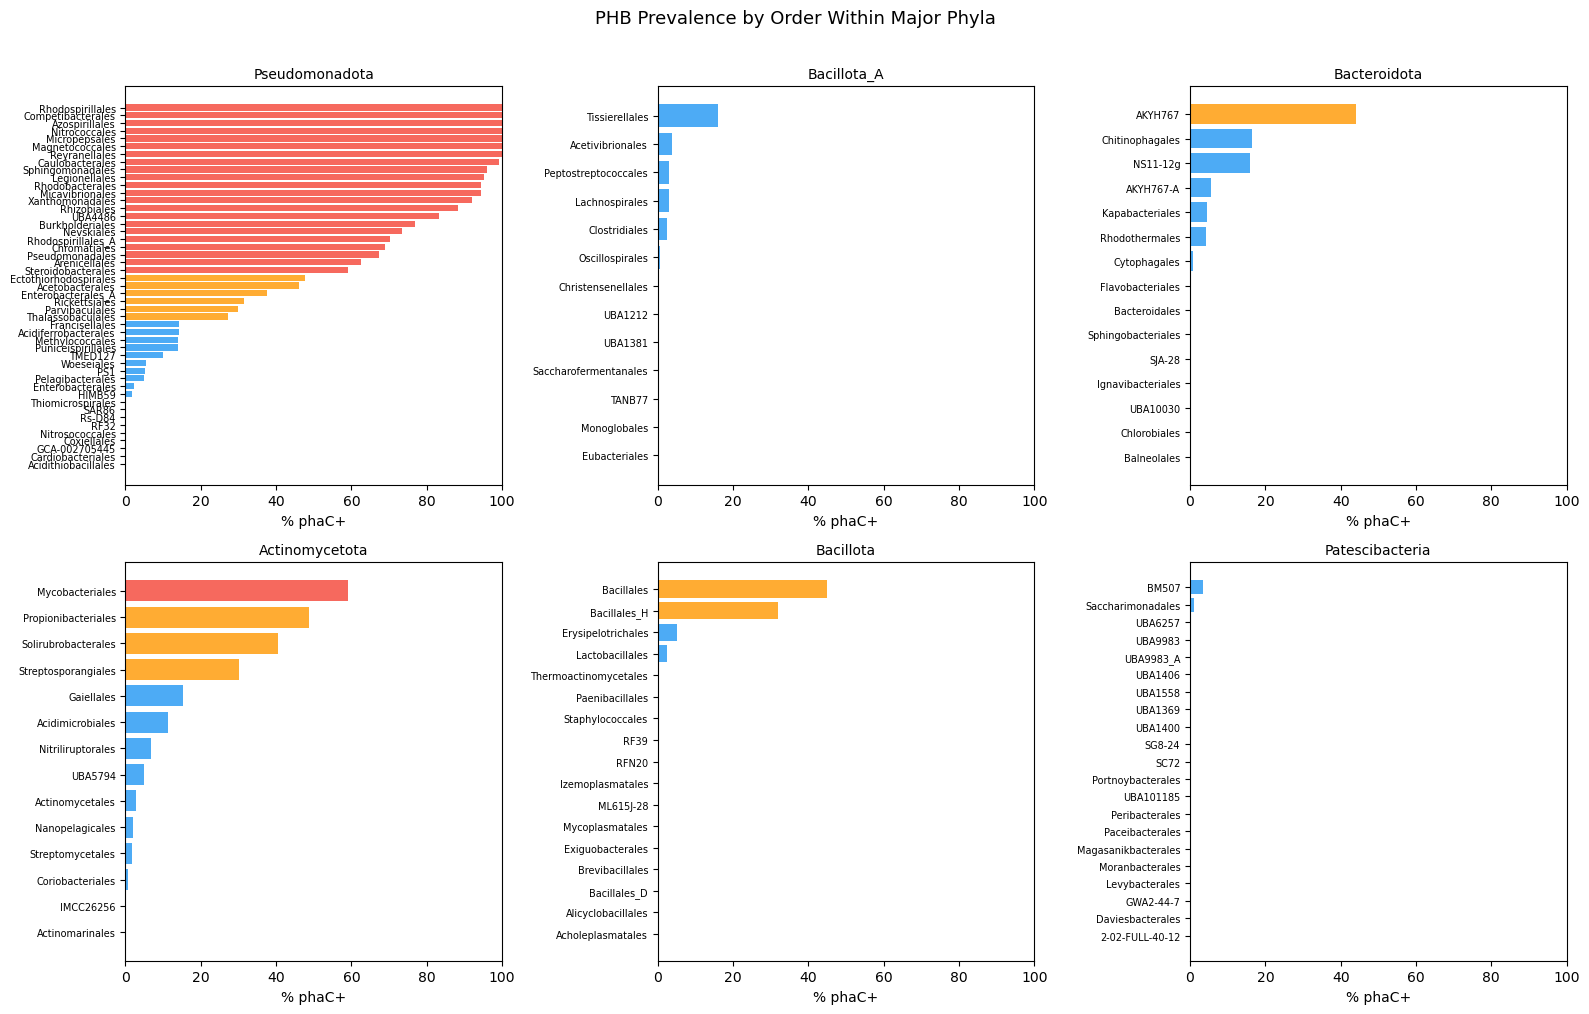

In [14]:
# Figure 1: PHB enrichment heatmap — order-level within top phyla
# Select phyla with >=5 orders that have >=10 species each

order_data = tax_phb.groupby(['gtdb_phylum', 'gtdb_order']).agg(
    n_species=('gtdb_species_clade_id', 'count'),
    pct_phaC=('has_phaC', lambda x: x.mean() * 100),
).reset_index()

order_data = order_data[order_data['n_species'] >= 10]

# Phyla with enough orders
phyla_with_orders = order_data.groupby('gtdb_phylum').filter(lambda x: len(x) >= 4)
top_phyla = phyla_with_orders.groupby('gtdb_phylum')['n_species'].sum().nlargest(6).index

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, phylum in enumerate(top_phyla):
    ax = axes[i]
    pdata = order_data[order_data['gtdb_phylum'] == phylum].sort_values('pct_phaC', ascending=True)
    
    # Clean order names
    labels = [o.replace('o__', '') for o in pdata['gtdb_order']]
    colors = ['#F44336' if p > 50 else '#FF9800' if p > 20 else '#2196F3' 
              for p in pdata['pct_phaC']]
    
    ax.barh(range(len(pdata)), pdata['pct_phaC'], color=colors, alpha=0.8)
    ax.set_yticks(range(len(pdata)))
    ax.set_yticklabels(labels, fontsize=7)
    ax.set_xlabel('% phaC+')
    ax.set_title(phylum.replace('p__', ''), fontsize=10)
    ax.set_xlim(0, 100)

plt.suptitle('PHB Prevalence by Order Within Major Phyla', fontsize=13, y=1.01)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'phb_enrichment_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

In [15]:
# Figure 2: Cross-validation — pangenome PHB prevalence vs NMDC abundance
if len(cross_val_df) > 10:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Scatter: pangenome phaC % vs NMDC mean abundance
    ax = axes[0]
    ax.scatter(cross_val_df['pangenome_pct_phaC'] * 100, 
               np.log10(cross_val_df['nmdc_mean_abundance'] + 1e-8),
               alpha=0.3, s=15, color='#2196F3')
    ax.set_xlabel('Pangenome phaC prevalence (% of species in genus)')
    ax.set_ylabel('log10(NMDC mean abundance)')
    ax.set_title('Pangenome PHB Prevalence vs\nNMDC Metagenomic Abundance')
    
    # Box: NMDC abundance of PHB-high vs PHB-low genera
    ax = axes[1]
    sns.boxplot(data=cross_val_df, x='phb_group', 
                y=np.log10(cross_val_df['nmdc_mean_abundance'] + 1e-8), 
                ax=ax, palette={'PHB-high (>=50%)': '#4CAF50', 'PHB-low (<50%)': '#9E9E9E'})
    ax.set_xlabel('Pangenome PHB group')
    ax.set_ylabel('log10(NMDC mean abundance)')
    ax.set_title(f'NMDC Abundance by PHB Group\n(Mann-Whitney p={p_val:.2e})')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'pangenome_vs_metagenome.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('Insufficient matched genera for cross-validation plot.')

Insufficient matched genera for cross-validation plot.


In [16]:
# Save all results
enrichment_df.to_csv(os.path.join(DATA_DIR, 'subclade_enrichment.tsv'), sep='\t', index=False)

phac_class_data = species_pha_class.merge(
    species_env[['gtdb_species_clade_id', 'primary_env', 'primary_variability']],
    on='gtdb_species_clade_id', how='left'
)
phac_class_data.to_csv(os.path.join(DATA_DIR, 'phaC_class_distribution.tsv'), sep='\t', index=False)

if len(cross_val_df) > 0:
    cross_val_df.to_csv(os.path.join(DATA_DIR, 'pangenome_vs_metagenome.tsv'), sep='\t', index=False)

print('Saved:')
print(f'  subclade_enrichment.tsv: {len(enrichment_df)} families')
print(f'  phaC_class_distribution.tsv: {len(phac_class_data)} species')
print(f'  pangenome_vs_metagenome.tsv: {len(cross_val_df)} genera')

Saved:
  subclade_enrichment.tsv: 248 families
  phaC_class_distribution.tsv: 6067 species
  pangenome_vs_metagenome.tsv: 0 genera


## Summary

### Key Findings (to be filled after execution)
- Enriched families (Bonferroni p<0.05): ?
- Depleted families: ?
- Do enriched families associate with variable environments?: ?
- PHA synthase class distribution: ?
- HGT candidates (discordant species): ?
- Pangenome-metagenome cross-validation: ?

### Interpretation
- If enriched families are in variable environments → supports ongoing environmental selection (H1d)
- If PHA synthase classes differ by environment → suggests ecological niche partitioning
- If discordant species have higher accessory phaC → supports HGT as mechanism
- If pangenome PHB prevalence correlates with NMDC abundance → independent validation